In [113]:
import numpy as np
import tensorflow as tf
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [114]:
class mnist_m_generator(object):
    def __init__(self, train_dir, test_dir):
        self.train_filelist = glob.glob(train_dir)
        self.test_filelist = glob.glob(test_dir)
        self.DS500_train_dataset= []
        self.DS500_test_dataset = []

        for fname in self.train_filelist:
            im = Image.open(fname)
            im = np.array(im.resize((321, 481)))

            self.DS500_train_dataset.append(im)

        for fname in self.test_filelist:
            im = Image.open(fname)
            im = np.array(im.resize((321, 481)))

            self.DS500_test_dataset.append(im)

        self.DS500_train_dataset = np.array(self.DS500_train_dataset)
        self.DS500_test_dataset = np.array(self.DS500_test_dataset)

    def create_mnistm(self, X_train, X_test):
        def compose_image(mnist_data, background_data):
            w, h, _ = background_data.shape
            dw, dh, _ = mnist_data.shape
            x = np.random.randint(0, w - dw)
            y = np.random.randint(0, h - dh)
            bg = background_data[x:x + dw, y:y + dh]
            return np.abs(bg - mnist_data).astype(np.uint8)

        def mnist_to_img(x):
            x = (x > 0).astype(np.float32)
            d = x.reshape([28, 28, 1]) * 255
            return np.concatenate([d, d, d], 2)

        minist_m_xtrain = np.zeros([X_train.shape[0], 28, 28, 3], np.uint8)
        for i in range(X_train.shape[0]):
            index = np.random.choice(self.DS500_train_dataset.shape[0], 1, replace=False)
            bg_img = self.DS500_train_dataset[index][0]
            
            mnist_image = mnist_to_img(X_train[i])

            mnist_image = compose_image(mnist_image, bg_img)
            minist_m_xtrain[i] = mnist_image

        minist_m_xtest = np.zeros([X_test.shape[0], 28, 28, 3], np.uint8)
        for i in range(X_test.shape[0]):
            index = np.random.choice(self.DS500_test_dataset.shape[0], 1, replace=False)

            bg_img = self.DS500_test_dataset[index][0]
            mnist_image = mnist_to_img(X_test[i])

            mnist_image = compose_image(mnist_image, bg_img)
            minist_m_xtest[i] = mnist_image

        return minist_m_xtrain, minist_m_xtest
        

In [115]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [116]:
minist_m_gen = mnist_m_generator('./images/train/*.jpg', './images/test/*.jpg')
minist_m_xtrain, minist_m_xtest = minist_m_gen.create_mnistm(X_train, X_test)

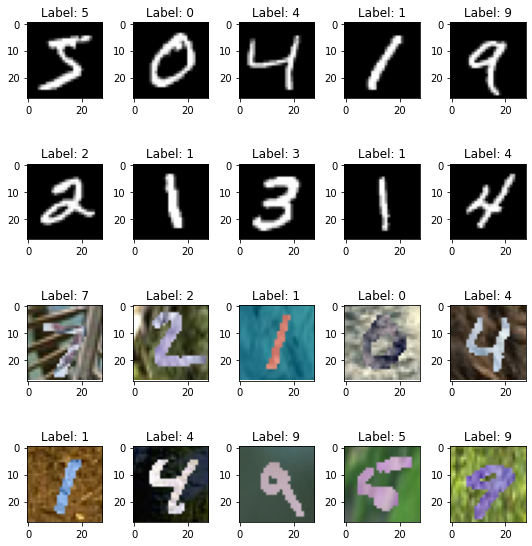

In [117]:
num_row = 4
num_col = 5
num = 10
images = X_train[:num]
labels = y_train[:num]

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))


images = minist_m_xtest[:num]
labels = y_test[:num]
for i in range(10,20):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i - 10], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i - 10]))
plt.tight_layout()
plt.show()